In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle


In [81]:
tf.random.set_seed(42)

In [85]:
import os
directory = './Stocks'

l = ['Date', 'Close']
stock= pd.DataFrame(columns=l)
for file in os.listdir(directory):
    f = os.path.join(directory, file)
    s = pd.read_csv(f)
    s = s[['Date', 'Close']]
    stock = pd.concat([stock, s])
    

In [86]:
stock

,Date,Close
0,1999-11-18,29.702
1,1999-11-19,27.257
2,1999-11-22,29.702
3,1999-11-23,27.002
4,1999-11-24,27.717
...,...,...
8153,2017-11-06,123.820
8154,2017-11-07,123.400
8155,2017-11-08,123.830
8156,2017-11-09,122.400


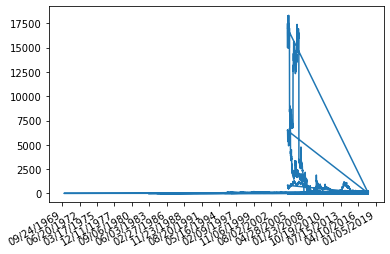

In [87]:
# Plotting the data
import datetime as dt

x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in stock['Date']]

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1000))
plt.plot(x, stock['Close'])
plt.gcf().autofmt_xdate()


In [88]:
from sklearn.preprocessing import MinMaxScaler

# making the dataset stationary
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset['Close'][i] - dataset['Close'][i - interval]
        diff.append(value)
    return pd.Series(diff)

def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]



# Transforming the dataset into -1 and +1 values for the tanh activation function
def scale_dataset(X):
    X = X.reshape(len(X), 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(X)
    scaled_X = scaler.transform(X)
    scaled_series = pd.Series(scaled_X[:, 0])
    return scaled_series, scaler



In [90]:
def get_train_test(dataset, train_test_ratio, n_days):
    n_train = int(len(dataset)*train_test_ratio)
    col_names = []
    for j in range(1, n_days+1):
        col_names.append(f'Price_{j}_db')
    col_names.append('Price_today')
    l = []
    for i in range(n_days, len(dataset)):
        l.append([])
        for j in range(1, n_days + 1):
            l[i-n_days].append(dataset.iloc[i-j])
        l[i-n_days].append(dataset.iloc[i])

    X = pd.DataFrame(l, columns=col_names)
    X = shuffle(X)
    train = X[:n_train]
    test = X[n_train:-1]
    return train, test

In [91]:
# diff_dataset = difference(stock)
scaled_dataset, scaler = scale_dataset(stock['Close'].to_numpy())
train, test = get_train_test(scaled_dataset, train_test_ratio=0.8, n_days=5)

train_y = train['Price_today']
train_X = train.drop(['Price_today'], axis=1)

test_y = test['Price_today']
test_X = train.drop(['Price_today'], axis=1)


In [92]:
Talvez minha LSTM esteja ao contrario, 

Eu coloco 1 dia antes -> 2 dias antes -> 3 dias antes -> 4 -> 5
Quando talvez fosse 5 ->4 -> 3 -> 2 -> 1 (com o mais recente por ultimo na LSTM)

SyntaxError: invalid syntax (<ipython-input-92-1bb22f209593>, line 1)

In [94]:
def fit_lstm(train_X, train_y, batch_size, n_epochs, n_neurons, dropout=0):
    train_y = train_y.to_numpy()
    train_X = train_X.to_numpy()
    train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
    model = Sequential()
    model.add(LSTM(n_neurons, activation='relu', input_shape=(train_X.shape[1], 1), dropout=dropout))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=batch_size, verbose=1, shuffle=False)

    return model, history

In [ ]:
model, history = fit_lstm(train_X, train_y, batch_size=1, n_epochs=10, n_neurons=20, dropout=0.2)

Epoch 1/10
216383/216383 [==============================] - 456s 2ms/step - loss: 5.3874e-04
Epoch 2/10
216383/216383 [==============================] - 458s 2ms/step - loss: 1.8560e-04
Epoch 3/10
216383/216383 [==============================] - 429s 2ms/step - loss: 1.5079e-04
Epoch 4/10
216383/216383 [==============================] - 429s 2ms/step - loss: 1.4673e-04
Epoch 5/10
216383/216383 [==============================] - 476s 2ms/step - loss: 1.5579e-04
Epoch 6/10
145279/216383 [===================>..........] - ETA: 2:31 - loss: 1.5109e-04

In [ ]:
# Plotting the loss throughout the epochs 
plt.plot(history.history['loss'][1:])
plt.show()

In [ ]:
def predict_value(days_before, scaler, model):
    db = days_before.to_numpy()
    db = db.reshape(len(db), 1)
    scaled_db = scaler.transform(db)
    scaled_predicted_price = model.predict(np.array([scaled_db]))
    predicted_price = scaler.inverse_transform(scaled_predicted_price)
    return predicted_price

In [ ]:
def plot_predicted_actual(X, y, scaler, model):
    

    #plt.plot(x) 
    x = range(np.shape(X)[0])
    
    #scaled predicted price
    spp = model.predict(X)
    upp = scaler.inverse_transform(spp)
    # unscaled y
    uy = scaler.inverse_transform(y.to_numpy().reshape(-1,1))
    
    plt.figure(figsize=(20,10))
    plt.plot(x[:100], uy[:100], color='red', label='Real price')
    plt.plot(upp[:100], color='blue', label='Predicted price')
    plt.xlabel('Instance')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
    return 

plot_predicted_actual(train_X, train_y, scaler, model)

In [ ]:
stock.iloc[2025:2030]['Close']

In [ ]:
stock.iloc[20030]['Close']

In [ ]:
predict_value(stock[20025:20030]['Close'], scaler, model)

In [ ]:
plot_predicted_actual(test_X, test_y, scaler, model)